In [1]:
import sys

sys.executable.split('/')[-3] == 'cda_venv'

True

In [2]:
import os
import random
import sys
import warnings

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tqdm import tqdm

sys.path.append('./')
from src.utils import *

tqdm.pandas()
warnings.filterwarnings('ignore')

seed_value = 2021
random.seed(seed_value)
np.random.seed(seed_value)

## Data loading and preparation

In [3]:
communication = pd.read_csv('data/communication.csv', sep=';')
reportsto = pd.read_csv('data/reportsto.csv', sep=';')

In [4]:
print(communication.info())
print('__'*50)
communication.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82927 entries, 0 to 82926
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sender     82927 non-null  int64 
 1   Recipient  82927 non-null  int64 
 2   EventDate  82927 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.9+ MB
None
____________________________________________________________________________________________________


,Sender,Recipient,EventDate
0,17,37,2010-01-02 17:40:10
1,17,136,2010-01-02 17:40:10
2,17,62,2010-01-02 17:40:10
3,17,129,2010-01-02 17:40:10
4,17,32,2010-01-02 17:40:10


In [5]:
reportsto['ReportsToID'].value_counts()

104                                                13
86                                                 12
141                                                11
36                                                  9
39                                                  8
136                                                 8
69                                                  8
70                                                  7
85                                                  7
90                                                  7
technical email account - not used by employees     7
former employee account                             6
148                                                 6
163                                                 5
27                                                  5
76                                                  4
154                                                 4
29                                                  4
143                         

In [6]:
reportsto = reportsto[
   (reportsto['ReportsToID'] != 'technical email account - not used by employees') &
   (reportsto['ReportsToID'] != 'former employee account')
].reset_index(drop=True)

reportsto['ReportsToID'] = reportsto['ReportsToID'].astype('int')

In [7]:
print(reportsto.info())
print('__'*50)
reportsto.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   ID           154 non-null    int64
 1   ReportsToID  154 non-null    int64
dtypes: int64(2)
memory usage: 2.5 KB
None
____________________________________________________________________________________________________


,ID,ReportsToID
0,1,152
1,2,132
2,3,152
3,5,36
4,6,163


## Graph building

In [8]:
high_mgmt = [86, 7, 27, 36, 69, 70, 85, 104, 121, 148, 156, 163]
mid_mgmt = [76, 90, 136, 137, 143, 152, 47, 162]

In [9]:
communication_groupby = communication.groupby(
    ['Sender', 'Recipient']
).size().to_frame('count').reset_index()

communication_groupby.head()

,Sender,Recipient,count
0,1,2,1
1,1,3,1
2,3,8,1
3,3,13,3
4,3,19,6


In [10]:
senders = list(communication['Sender'].unique())
recipients = list(communication['Recipient'].unique())
reportstos = list(reportsto['ID'].unique())

unique_ids = []
unique_ids.extend(senders)
unique_ids.extend(recipients)
unique_ids.extend(reportstos)
unique_ids = list(set(unique_ids))

print(f'Number of employee ids in dataset: {len(unique_ids)}')


employee_ids = sorted(reportsto['ID'].unique())
min_employee_id = min(employee_ids)
max_employee_id = max(employee_ids)

ids_not_in_reportsto = []
for i in range(min_employee_id, max_employee_id+1):
    if i not in employee_ids:
        ids_not_in_reportsto.append(i)

print(f'Number of employee ids not in reportsto: {len(ids_not_in_reportsto)}')

Number of employee ids in dataset: 167
Number of employee ids not in reportsto: 13


In [11]:
G_communication = build_communication_graph(
    communication_df=communication_groupby,
    employee_ids_range=(min_employee_id, max_employee_id)
)

Number of nodes: 167
Number of edges: 3251
Number of connected components: 1


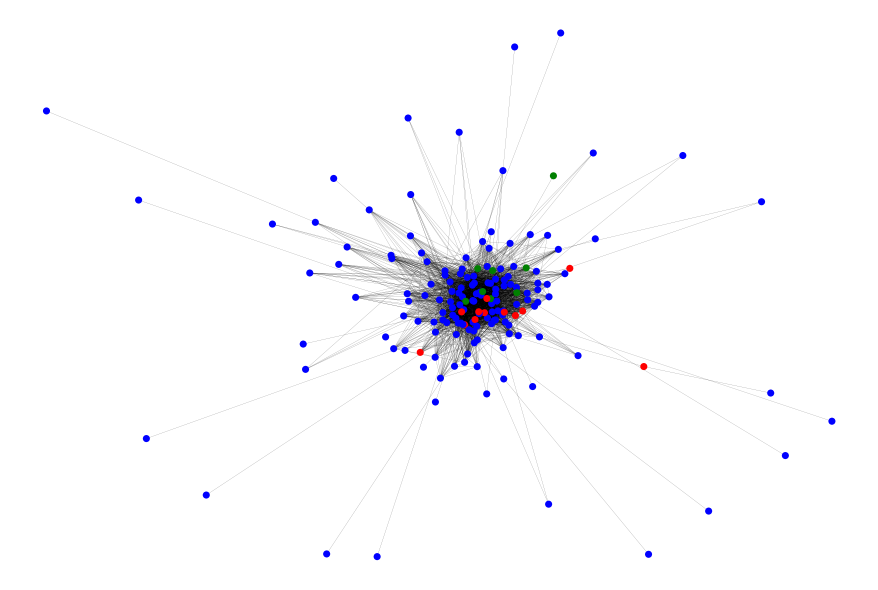

In [12]:
graph_info(G_communication)
draw_graph(G_communication, high_mgmt, mid_mgmt)

In [13]:
G_reportsto = build_reportsto_graph(
    reportsto_df=reportsto,
    employee_ids_range=(min_employee_id, max_employee_id)
)

Number of nodes: 167
Number of edges: 154
Number of connected components: 14


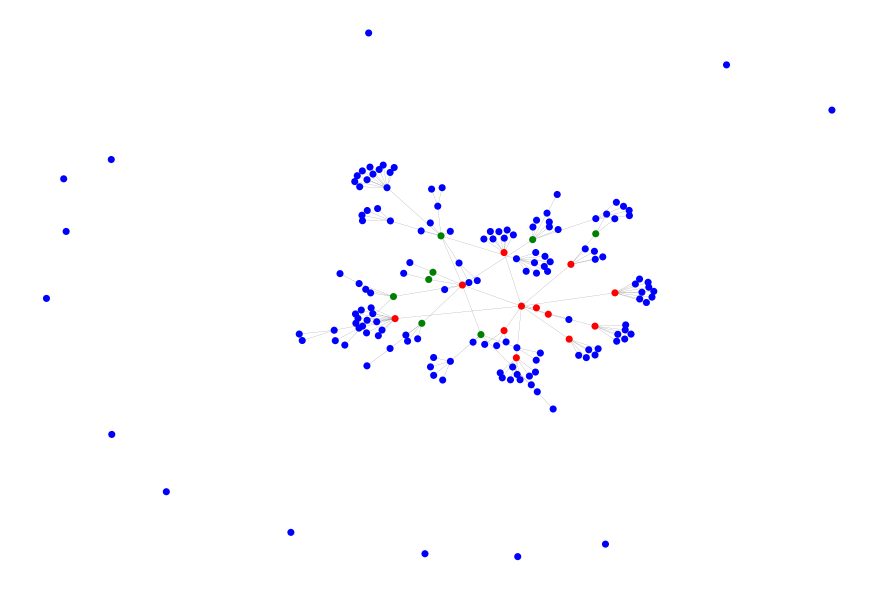

In [14]:
graph_info(G_reportsto)
draw_graph(G_reportsto, high_mgmt, mid_mgmt)

## Graph attributes

Dataframe: Number of employees that report to specific employee

In [15]:
reportsto_grupby_reportsToID = reportsto.groupby(
    ['ReportsToID']
).size().to_frame('count').reset_index()

reportsto_grupby_reportsToID.head()

,ReportsToID,count
0,19,2
1,27,5
2,29,4
3,31,1
4,33,2


Dataframe: Number of emails sent by employee

In [16]:
communication_groupby_sender = communication.groupby(
    ['Sender']
).size().to_frame('count').reset_index()

communication_groupby_sender.head()

,Sender,count
0,1,2
1,3,331
2,4,1
3,5,64
4,6,2


Dataframe: Number of emails received by employees

In [17]:
communication_groupby_recipient = communication.groupby(
    ['Recipient']
).size().to_frame('count').reset_index()

communication_groupby_recipient.head()

,Recipient,count
0,2,31
1,3,558
2,7,8
3,8,1069
4,11,2525


In [18]:
node = 3

try:
    reporters_num = int(reportsto_grupby_reportsToID[
        reportsto_grupby_reportsToID['ReportsToID'] == node
    ]['count'])
except TypeError:
    reporters_num = 0

try:
    emails_sent_num = int(communication_groupby_sender[
        communication_groupby_sender['Sender'] == node
    ]['count'])
except TypeError:
    emails_sent_num = 0

try:
    emails_received_num = int(communication_groupby_recipient[
        communication_groupby_recipient['Recipient'] == node
    ]['count'])
except TypeError:
    emails_received_num = 0

print(reporters_num)
print(emails_sent_num)
print(emails_received_num)

0
331
558


## ICA

In [20]:
G = build_communication_graph(
    communication_df=communication_groupby,
    employee_ids_range=(min_employee_id, max_employee_id)
)

set_static_attrs(
    G=G,
    reportsto_grupby_reportsToID=reportsto_grupby_reportsToID, 
    communication_groupby_sender=communication_groupby_sender, 
    communication_groupby_recipient=communication_groupby_recipient
)
set_network_attributes(G)

### ICA test

In [21]:
y_true, y_pred = ica(
    G=G, 
    sorted_by='closeness',
    clf=RandomForestClassifier(random_state=seed_value),
    high_mgmt=high_mgmt,
    mid_mgmt=mid_mgmt,
    uncover_nodes_percentage=0.25,
    iterations=100
)

In [22]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       116
           1       0.00      0.00      0.00         4
           2       0.67      0.33      0.44         6

    accuracy                           0.93       126
   macro avg       0.53      0.44      0.47       126
weighted avg       0.89      0.93      0.91       126



### ICA experiments

In [23]:
uncover_nodes_percentages = list(map(lambda x: x/100.0, range(5, 51, 5)))
sorted_by_list = [
    'degree', 
    'closeness', 
    'betweenness', 
    'pagerank', 
    'eigenvector'
]
clfs = [
    RandomForestClassifier(random_state=seed_value), 
    AdaBoostClassifier(random_state=seed_value)
]
iterations_list = [25]

def ica_experiments():
    results_df = pd.DataFrame()
    for uncover_nodes_percentage in tqdm(uncover_nodes_percentages):
        for s_by in sorted_by_list:
            for clf in clfs:
                for iters in iterations_list:
                    G = build_communication_graph(
                        communication_df=communication_groupby,
                        employee_ids_range=(min_employee_id, max_employee_id)
                    )

                    set_static_attrs(
                        G=G,
                        reportsto_grupby_reportsToID=reportsto_grupby_reportsToID, 
                        communication_groupby_sender=communication_groupby_sender, 
                        communication_groupby_recipient=communication_groupby_recipient
                    )
                    set_network_attributes(G)

                    y_true, y_pred = ica(
                        G=G, 
                        sorted_by=s_by,
                        clf=clf,
                        high_mgmt=high_mgmt,
                        mid_mgmt=mid_mgmt,
                        uncover_nodes_percentage=uncover_nodes_percentage,
                        iterations=iters
                    )

                    results_df = results_df.append({
                        'uncover_percentage': uncover_nodes_percentage, 
                        'sorted_by': s_by, 
                        'clf': clf.__class__.__name__, 
                        'iterations': int(iters), 
                        'accuracy': accuracy_score(y_true, y_pred), 
                        'precision': precision_score(y_true, y_pred, average='macro'),
                        'recall': recall_score(y_true, y_pred, average='macro'),
                        'f1_score': f1_score(y_true, y_pred, average='macro')
                    }, ignore_index=True)

    return results_df

results_df = ica_experiments()

100%|██████████| 10/10 [07:18<00:00, 43.83s/it]


In [24]:
results_df.sort_values(by=['f1_score'], ascending=False).head(50)

,accuracy,clf,f1_score,iterations,precision,recall,sorted_by,uncover_percentage
73,0.940594,AdaBoostClassifier,0.611955,25.0,0.631797,0.604019,closeness,0.40
30,0.910448,RandomForestClassifier,0.601154,25.0,0.595863,0.611339,degree,0.20
33,0.880597,AdaBoostClassifier,0.531751,25.0,0.497076,0.651471,closeness,0.20
31,0.873134,AdaBoostClassifier,0.524718,25.0,0.494152,0.639344,degree,0.20
95,0.809524,AdaBoostClassifier,0.505202,25.0,0.517247,0.608333,betweenness,0.50
38,0.917910,RandomForestClassifier,0.504968,25.0,0.483871,0.530738,eigenvector,0.20
25,0.901408,AdaBoostClassifier,0.500772,25.0,0.469092,0.544974,betweenness,0.15
58,0.923077,RandomForestClassifier,0.500258,25.0,0.457321,0.587654,eigenvector,0.30
96,0.940476,RandomForestClassifier,0.489648,25.0,0.646586,0.444444,pagerank,0.50
32,0.888060,RandomForestClassifier,0.481869,25.0,0.442360,0.591947,closeness,0.20


In [25]:
results_df.sort_values(by=['f1_score'], ascending=False).tail(50)

,accuracy,clf,f1_score,iterations,precision,recall,sorted_by,uncover_percentage
75,0.712871,AdaBoostClassifier,0.322791,25.0,0.347063,0.470449,betweenness,0.40
74,0.712871,RandomForestClassifier,0.322452,25.0,0.344326,0.414894,betweenness,0.40
83,0.923913,AdaBoostClassifier,0.321970,25.0,0.318352,0.325670,closeness,0.45
52,0.931624,RandomForestClassifier,0.321534,25.0,0.310541,0.333333,closeness,0.30
53,0.931624,AdaBoostClassifier,0.321534,25.0,0.310541,0.333333,closeness,0.30
72,0.930693,RandomForestClassifier,0.321368,25.0,0.310231,0.333333,closeness,0.40
7,0.874214,AdaBoostClassifier,0.320646,25.0,0.313063,0.328605,pagerank,0.05
69,0.926606,AdaBoostClassifier,0.320635,25.0,0.308869,0.333333,eigenvector,0.35
68,0.926606,RandomForestClassifier,0.320635,25.0,0.308869,0.333333,eigenvector,0.35
62,0.926606,RandomForestClassifier,0.320635,25.0,0.308869,0.333333,closeness,0.35


In [26]:
results_df.to_csv('out/results_ica.csv')

### Plot results for AdaBoostClassifier

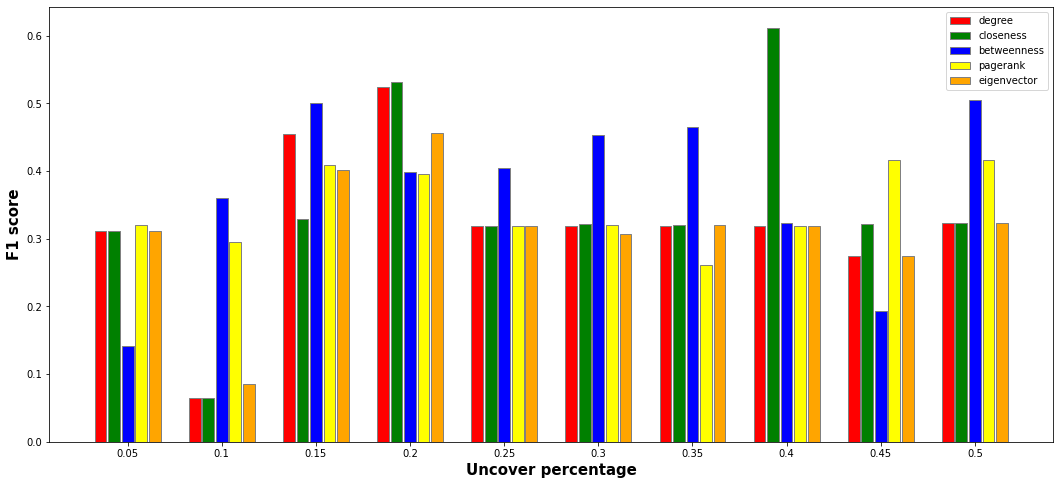

In [27]:
barWidth = 0.125
fig = plt.subplots(figsize =(18, 8)) 
 
# set height of bar
degree = get_uncover_percentage_f1s(results_df, sorted_by='degree')
closeness = get_uncover_percentage_f1s(results_df, sorted_by='closeness')
betweenness = get_uncover_percentage_f1s(results_df, sorted_by='betweenness')
pagerank = get_uncover_percentage_f1s(results_df, sorted_by='pagerank')
eigenvector = get_uncover_percentage_f1s(results_df, sorted_by='eigenvector')
 
# Set position of bar on X axis 
br1 = np.arange(len(degree)) 
br2 = [x + barWidth*1.15 for x in br1] 
br3 = [x + barWidth*1.15 for x in br2]
br4 = [x + barWidth*1.15 for x in br3] 
br5 = [x + barWidth*1.15 for x in br4]
 
# Make the plot
plt.bar(br1, degree, color='r', width=barWidth, 
        edgecolor='grey', label='degree') 
plt.bar(br2, closeness, color='g', width = barWidth, 
        edgecolor='grey', label='closeness') 
plt.bar(br3, betweenness, color='b', width = barWidth, 
        edgecolor='grey', label='betweenness')
plt.bar(br4, pagerank, color='yellow', width = barWidth, 
        edgecolor='grey', label='pagerank') 
plt.bar(br5, eigenvector, color='orange', width = barWidth, 
        edgecolor='grey', label='eigenvector') 
 
# Adding Xticks 
plt.xlabel('Uncover percentage', fontweight ='bold', fontsize = 15) 
plt.ylabel('F1 score', fontweight ='bold', fontsize = 15) 
plt.xticks([r + 2*barWidth*1.15 for r in range(len(degree))], 
        uncover_nodes_percentages)
 
plt.legend()
plt.show() 

## Random classifier

In [28]:
uncover_nodes_percentages = list(map(lambda x: x/100.0, range(5, 51, 5)))
clfs = [
    RandomForestClassifier(random_state=seed_value), 
    AdaBoostClassifier(random_state=seed_value)
]
iterations = 25

def random_experiments():
    results_df_random = pd.DataFrame()
    for uncover_nodes_percentage in tqdm(uncover_nodes_percentages):
        for clf in clfs:
            for _ in range(iterations):
                G = build_communication_graph(
                    communication_df=communication_groupby,
                    employee_ids_range=(min_employee_id, max_employee_id)
                )

                set_static_attrs(
                    G=G,
                    reportsto_grupby_reportsToID=reportsto_grupby_reportsToID, 
                    communication_groupby_sender=communication_groupby_sender, 
                    communication_groupby_recipient=communication_groupby_recipient
                )
                set_network_attributes(G)

                y_true, y_pred = random_clf(
                    G=G, 
                    clf=clf, 
                    high_mgmt=high_mgmt, 
                    mid_mgmt=mid_mgmt, 
                    uncover_nodes_percentage=uncover_nodes_percentage
                )

                results_df_random = results_df_random.append({
                    'uncover_percentage': uncover_nodes_percentage, 
                    'clf': clf.__class__.__name__, 
                    'accuracy': accuracy_score(y_true, y_pred), 
                    'precision': precision_score(y_true, y_pred, average='macro'),
                    'recall': recall_score(y_true, y_pred, average='macro'),
                    'f1_score': f1_score(y_true, y_pred, average='macro')
                }, ignore_index=True)

    return results_df_random

results_df_random = random_experiments()

100%|██████████| 10/10 [15:02<00:00, 90.21s/it]


In [29]:
results_df_random.groupby(['clf', 'uncover_percentage'])['accuracy', 'precision', 'recall', 'f1_score'].mean()\
    .sort_values(by=['f1_score'], ascending=False)

accuracy  precision    recall  \
clf                    uncover_percentage                                  
AdaBoostClassifier     0.50                0.857619   0.504157  0.518239   
                       0.20                0.866269   0.470353  0.483696   
                       0.45                0.850870   0.473137  0.462598   
                       0.15                0.845915   0.437598  0.499951   
                       0.35                0.859450   0.448009  0.457888   
                       0.30                0.866667   0.461234  0.492238   
                       0.40                0.798416   0.440960  0.452824   
                       0.10                0.835497   0.397960  0.450470   
                       0.25                0.755238   0.412539  0.430448   
RandomForestClassifier 0.30                0.881368   0.425634  0.388049   
AdaBoostClassifier     0.05                0.827673   0.396130  0.415297   
RandomForestClassifier 0.35                0.878899   0.412539  0.398492   
                       0.45                0.870435   0.402689  0.390414   
                       0.50                0.881905   0.399157  0.389242   
                       0.25                0.882222   0.397660  0.384809   
                       0.40                0.877228   0.401474  0.370702   
                       0.10                0.873377   0.386396  0.371472   
                       0.15                0.875775   0.378876  0.375973   
                       0.05                0.864654   0.355416  0.366890   
                       0.20                0.875522   0.391245  0.359955   

                                           f1_score  
clf                    uncover_percentage            
AdaBoostClassifier     0.50                0.492874  
                       0.20                0.460020  
                       0.45                0.448087  
                       0.15                0.445578  
                       0.35                0.444614  
                       0.30                0.438722  
                       0.40                0.423477  
                       0.10                0.404883  
                       0.25                0.390705  
RandomForestClassifier 0.30                0.389711  
AdaBoostClassifier     0.05                0.389389  
RandomForestClassifier 0.35                0.387181  
                       0.45                0.381656  
                       0.50                0.380037  
                       0.25                0.376421  
                       0.40                0.367805  
                       0.10                0.365283  
                       0.15                0.361437  
                       0.05                0.353433  
                       0.20                0.351418

In [30]:
results_df_random.to_csv('out/results_random.csv')

## Summary

### Podsumowanie
Zaimplementowano wybrany algorytm klasyfikacji kolektywnej - ICA (Iterative Classification Algorithm) dla zadania klasyfikacji etykiet grup pracowników. Kolejno przeprowadzono badania dotyczące wyboru węzłów początkowych do odkrycia etykiet (metoda wyboru, procent odkrytych etykiet i rodzaj klasyfikatora wewnętrznego). Dodatkowo zaimplementowano algorytm losowy dla analogicznego zadania oraz zestawiono otrzymane wyniki. Dla kompletu eksperymentów zapisywano wskazania metryk dokładności, precyzji, czułości oraz miary F1, z których ostatnia głównie posłużyła do pomiaru skuteczności klasyfikacj i porównywania wyników.



### ICA
Jeżeli chodzi o algorytm ICA, zbadano wpływ następujących parametrów na otzymywane wyniki:
- procent odkrytych etykiet
    - badano 10 wartości: {0.05, 0.1, 0.15, ..., 0.5}
- metoda wyboru węzłów początkowych
    - wybór na podstawie następujących metryk sieciowych: {degree, closeness, betweenness, pagerank, eigenvector}
- klasyfikator wewnętrzny
    - RandomForest oraz AdaBoost (pakiet scikit-learn)

 
Zestawienie ustawień parametrów dla trzech najwyższych wyników miary F1:
- #1 (F1 = 0.611955)
    - procent odkrytych etykiet: 40%
    - metoda wyboru węzłów początkowych: closeness
    - klasyfikator wewnętrzny: AdaBoost
- #2 (F1 = 0.601154)
    - procent odkrytych etykiet: 20%
    - metoda wyboru węzłów początkowych: degree
    - klasyfikator wewnętrzny: RandomForest
- #3 (F1 = 0.531751)
    - procent odkrytych etykiet: 20%
    - metoda wyboru węzłów początkowych: closeness
    - klasyfikator wewnętrzny: AdaBoost



### Podejście losowe
Badanie wykonane na podstawie średnich wyników z 25 powtórzeń każdej konfiguracji.

Dla podejścia losowego natomiast, badane parametry to:
- procent odkrytych etykiet
    - badano 10 wartości: {0.05, 0.1, 0.15, ..., 0.5}
- klasyfikator
    - RandomForest oraz AdaBoost (pakiet scikit-learn)


Zestawienie ustawień parametrów dla trzech najwyższych wyników miary F1:
- #1 (F1 = 0.492874)
    - procent odkrytych etykiet: 50%
    - klasyfikator wewnętrzny: AdaBoost
- #2 (F1 = 0.444403)
    - procent odkrytych etykiet: 20%
    - klasyfikator wewnętrzny: AdaBoost
- #3 (F1 = 0.443456)
    - procent odkrytych etykiet: 45%
    - klasyfikator wewnętrzny: AdaBoost



### Wnioski
- klasyfikator AdaBoost sprawdza się lepiej
    - ICA: 4 z pierwszych 5 pozycji
    - Podejście losowe: 5 z pierwszych 5 pozycji
- algorytm ICA sprawdza się dla analizowanego problemu, wyniki nie są idealne, natomiast są zauważalnie lepsze od podejścia losowego (#1 F1 dla ICA to ok. 61%, dla podejścia losowego ok. 49%)
- dla podejścia losowego nie zauważono jasnej zależności między procentem odkrytych etykiet a odczytywanymi wskazaniami metryk, natomiast dla ICA odkrycie etykiet w zakresie 15-20% szczególnie sprawdziło się dla różnych metryk sieciowych (z kolei najwyższych wynik miary F1 uzyskano dla odkrycia 40% etykiet)
- closeness i degree to cechy, które zdają się najlepiej sprawdzać przy doborze węzłów do odkrycia